# Network construction 

Network construction is aligned with the questions we aim to answer in the project. For this, the nodes represent the deputies. Two deputies are linked if their voting pattern is similar, which will be made clear below. 

We consider the votings that occurred during a legislature (presidential term) in the plenary, from 2003 (legislature 52) to 2021 (legislature 56). 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time
from tqdm.notebook import trange, tqdm
import json

First, the metrics will be tested in the 56th legislature. Then, we extend to the past periods. The incidence matrix was already built. 

In [2]:
incidence_matrix = pd.read_csv('../data/tables/incidence_matrix_56.csv', index_col = 0)

The vote mapping is the following. Note that besides the above, the deputy can be absent (what is quite common in several votes). 

In [3]:
with open('../data/tables/vote_mapping.json') as f: 
    vote_mapping = json.load(f)
    
vote_mapping

{'Não': -1,
 'Sim': 1,
 'Abstenção': 0,
 'Secreto': 278,
 'Artigo 17': 17,
 'Branco': 255,
 'Obstrução': 0.1,
 'Favorável com restrições': 0.5}

## Description of the votes

The `Não` indicates that the deputy is AGAINST what is being votes, while `Sim` indicates that they are FOR it. The secret vote is `Secreto`. We deal with it as unknown. The same for `Branco`, which can be translated to IGNORED. The `Artigo 17` is placed when the president of the session does not vote according to the [bylaws of the Chamber of Deputies](https://bd.camara.leg.br/bd/bitstream/handle/bdcamara/18847/regimento_interno_3ed.pdf?sequence=29&isAllowed=y). Therefore we treat it as unknown either. The following are open to discussion and can be controversial: 

1. `Abstenção`: when the deputy is in the voting section and abstains its votes. There are four different approaches in the literature: 
    - Treat as unknown information: If the deputy abstains the vote, its value will be 0. 
    - Treat as partial information: If one deputy abstains to a vote, and the other agrees, we say they half agree. The same for disagreement. 
    - Treat as partial information and unknown information: If two deputies abstain, we say they agree. If one abstains and the other does not, we say there is 0 information. 
    - Treat as strong information: An abstention is equivalently to agreement with the majority.  
    
2. `Favorável com restrições`: This occured less than 0.0027% of the votes in the whole period. We can therefore assign a positive value $p ain (0,1)$ for this kind of vote. Non treatment was found in the litereature for this kind of vote and we think it does not interfeer to much. 

3. `Absence`: Generally the absence is treated as 0, but it can indicate agreemento or disagreement depending on the strategy of the deputy. Since it is difficult to determine, we treat as unknown information. 


4. `Obstruction`: 

> "Such practice is used to create difficulties or hindrances in a systematic way to
delay or impede the approval of a bill in parliament. It is normally used by minority groups
which do not have the necessary number of representatives to effectively hold back a decision
taken by the majority. Therefore, any vote marked as obstruction is here regarded as AGAINST."

Besides that, there are different metrics we can use to measure the similarity between two deputies.    

### First option [1] 

Let $M_{ij}^t \in  \{-1,+1\}$ such that is -1 if the deputies have different votes and +1 if they have the same. This metric does not have any prior consideration regarding the type of vote. Moreover $t$ is a voting index. Let $W_{ij}^n = \sum_{t=0}^n M_{ij}^t \in [-n,n]$. In our work, we will have only five of this matrix, one for each legislature. After that, 

$$
G_{ij}^n = 
\begin{cases}
    W_{ij}^n, &\text{if } W_{ij}^n = \max_{\forall x \in W_i^n} x \\
    0 &\text{otherwise.}
\end{cases}
$$

This metric creates a directed graph. An additional ideia is to create an unique big graph such that the edges are of the form $(i,j,t)$, where $i,j$ are deputies, and $t$ is the temporal slice. 

### Second option [2, 3] 

Let $v^{(i)}$ be a vector for the ith deputy such that 

$$
v^{(i)}_k = \begin{cases}
+1 &\text{if the deputy is favor of the vote } j \\
p \in (0,1) &\text{if the deputy is favorable with restrictions in vote } j \\
0 &\text{if the information is unknown in vote } j \\
-1 &\text{if the deputy is against of the vote } j
\end{cases}
$$

Note that the comments about obstruction and abstention hold in this case. Therefore 

$$
w_{ij} = \frac{1}{n}\langle v^{(i)}, v^{(j)} \rangle.
$$

## Building the adjacency matrix

We start with the possibilities of the second option. For legislature 56, there is only the following votes: 

In [4]:
a = np.unique(incidence_matrix.values.flatten())
a[~np.isnan(a)]

array([-1. ,  0. ,  0.1,  1. , 17. ])

In [40]:
def build_adjacency_matrix_from_inner_product(incidence_matrix, abstention_decision, obstruction_decision): 
    """
    This functions builds the adjacency matrix given a decision: 
    - The -1 and +1 is kept. 
    - The NaN are filled with 0. 
    - The 17 is replaced with 0. 
    - The 0.1 is replaced depending on the decision.
    - The 0 is replaced depending on the decision.
    """
    incidence_matrix = incidence_matrix.replace({17: np.nan})
    if obstruction_decision == 'against': 
        incidence_matrix = incidence_matrix.replace({0.1: -1}) 
    elif obstruction_decision == 'unknown': 
        incidence_matrix = incidence_matrix.replace({0.1: np.nan})
    elif obstruction_decision == 'same':
        pass
    else: 
        raise Exception('The decision for obstruction {} was not programmed'.format(obstruction_decision))
    
    if abstention_decision == 'unknown': 
        pass
    elif abstention_decision == 'partial' or abstention_decision == 'partial-unknown' or abstention_decision == 'same': 
        incidence_matrix = incidence_matrix.replace({0: 0.5})
    elif abstention_decision == 'strong': 
        for voting, votes in incidence_matrix.iterrows():  
            majority = np.sign(votes.sum()) 
            incidence_matrix.loc[voting] = incidence_matrix.loc[voting].replace({0: majority})
    else: 
        raise Exception('The decision for abstention {} was not programmed'.format(abstention_decision))
        
    incidence_matrix = incidence_matrix.fillna(0)
    
    n = incidence_matrix.shape[0]
    
    if abstention_decision == 'unknown' or abstention_decision == 'strong': 
        metric = lambda u1, u2: np.inner(u1, u2)
    elif abstention_decision == 'partial': 
        metric = lambda u1, u2: np.inner(u1, u2) + sum(0.25*((u1 == u2)&(u1 == 0.5)) + 1*(u1 + u2 == -0.5))
    elif abstention_decision == 'partial-unknown': 
        metric = lambda u1, u2: sum(1*(u1 - u2 == 0) - 1*(u1 + u2 == 0))
    elif abstention_decision == 'same': 
        metric = lambda u1, u2: sum(1*(u1 == u2)&(u1 != 0))
        
    adj = incidence_matrix.corr(method = metric)/n 
    
    return adj

Let's try this out. 

In [38]:
adjacency_matrix = build_adjacency_matrix_from_inner_product(incidence_matrix, 'unknown', 'against')
adjacency_matrix2 = build_adjacency_matrix_from_inner_product(incidence_matrix, 'unknown', 'unknown')
ind = np.triu_indices(n = adjacency_matrix.shape[0], k = 1)

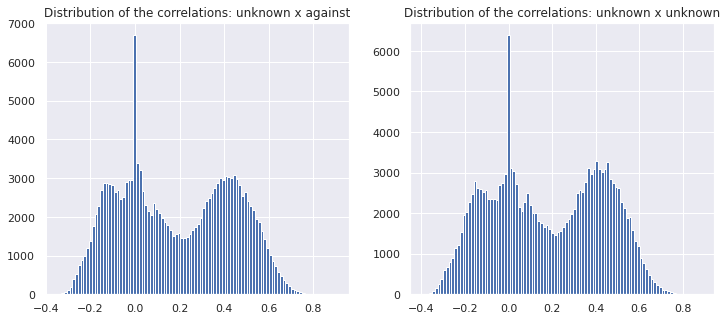

In [39]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].hist(adjacency_matrix.values[ind], bins = 100)
ax[0].set_title("Distribution of the correlations: unknown x against")
ax[1].hist(adjacency_matrix2.values[ind], bins = 100)
ax[1].set_title("Distribution of the correlations: unknown x unknown")
plt.show()

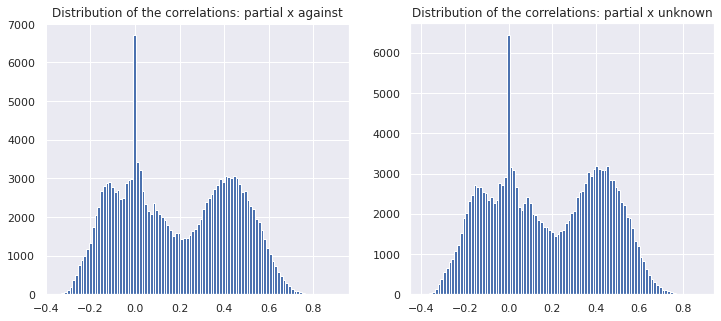

In [41]:
adjacency_matrix = build_adjacency_matrix_from_inner_product(incidence_matrix, 'partial', 'against')
adjacency_matrix2 = build_adjacency_matrix_from_inner_product(incidence_matrix, 'partial', 'unknown')

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].hist(adjacency_matrix.values[ind], bins = 100)
ax[0].set_title("Distribution of the correlations: partial x against")
ax[1].hist(adjacency_matrix2.values[ind], bins = 100)
ax[1].set_title("Distribution of the correlations: partial x unknown")
plt.show()

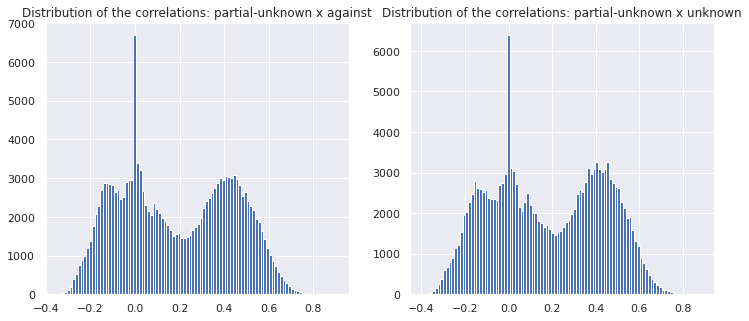

In [35]:
adjacency_matrix = build_adjacency_matrix_from_inner_product(incidence_matrix, 'partial-unknown', 'against')
adjacency_matrix2 = build_adjacency_matrix_from_inner_product(incidence_matrix, 'partial-unknown', 'unknown')

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].hist(adjacency_matrix.values[ind], bins = 100)
ax[0].set_title("Distribution of the correlations: partial-unknown x against")
ax[1].hist(adjacency_matrix2.values[ind], bins = 100)
ax[1].set_title("Distribution of the correlations: partial-unknown x unknown")
plt.show()

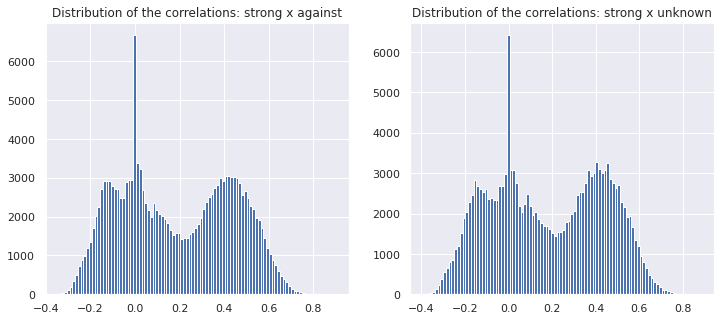

In [36]:
adjacency_matrix = build_adjacency_matrix_from_inner_product(incidence_matrix, 'strong', 'against')
adjacency_matrix2 = build_adjacency_matrix_from_inner_product(incidence_matrix, 'strong', 'unknown')

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].hist(adjacency_matrix.values[ind], bins = 100)
ax[0].set_title("Distribution of the correlations: strong x against")
ax[1].hist(adjacency_matrix2.values[ind], bins = 100)
ax[1].set_title("Distribution of the correlations: strong x unknown")
plt.show()

# References 

[1] Colliri, T., Zhao, L. Analyzing the Bills-Voting Dynamics and Predicting Corruption-Convictions Among Brazilian Congressmen Through Temporal Networks. Sci Rep 9, 16754 (2019). https://doi.org/10.1038/s41598-019-53252-9

[2] Mario Levorato, Yuri Frota. Brazilian Congress structural balance analysis. Journal of Interdisciplinary Methodologies and Issues in Science, Journal of Interdisciplinary Methodologies and Issues in Science, 2017, Graphs & Social Systems, Graphs and social systems, 10.18713/JIMIS-280217-2-3. hal-01359672v4

[3] Brito ACM, Silva FN, Amancio DR (2020) A complex network approach to political analysis: Application to the Brazilian Chamber of Deputies. PLOS ONE 15(3): e0229928. https://doi.org/10.1371/journal.pone.0229928